# ロジスティック回帰モデル

---

## 本資料の概要

### 目的

Pythonでロジスティック回帰モデルを構築する方法を説明する。  
また、モデル構築時の注意点を踏まえたモデルの改善方法も合わせて説明する。

### 構成

モデル構築を3回繰り返し、モデル構築時の注意点を一つずつ解消していく。

- 1回目：素の変数でモデル構築
    - 顧客が定期預金を申し込む仕組みについて仮説を立てる。
    - 立てた仮説にもとづいて、モデルと説明変数を選ぶ。
- 2回目：`age` の線形化
    - 説明変数の線形性を確認し、非線形な説明変数について仮説を立て直す。
    - 立て直した仮説にもとづいて、説明変数を線形化する。
- 3回目：`balance` の外れ値処理
    - 説明変数の分布を確認し、外れ値を含む説明変数について仮説を立て直す。
    - 立て直した仮説にもとづいて、外れ値を処理する。

---

## セットアップ

### モジュールの読み込み

In [1]:
# 多次元配列やデータフレームの操作
import numpy as np
import pandas as pd

# ロジスティックス回帰モデル
from sklearn.linear_model import LogisticRegression

# クロスバリデーション
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

# グラフの描画
from matplotlib import pyplot as plt

### パスの設定

In [2]:
# データの場所
input_path = '../input_data/bank/'

# 提出ファイルを出力する場所
submit_path = '../submit/bank/'

### データの読み込み

In [3]:
train_df = pd.read_csv(input_path + 'train.csv')
test_df = pd.read_csv(input_path + 'test.csv')

train = train_df.copy()
test = test_df.copy()

---

## 1回目：素の変数でモデル構築

### 仮説の設定

定期預金を申し込む欲求は以下の要因によって決まると考えた。  
また、各要因が増すと欲求も単調に増加すると考えられることから、  
欲求を要因の線形和で表現したモデルであるロジスティック回帰モデルを用いることにした。

- 定期預金の必要性
    - 定期預金の必要性が増すと、定期預金を申し込む欲求も増す。
- 資産的余裕
    - 資産的余裕が増すと、定期預金を申し込む欲求も増す。

そして、各要因を表す変数として、以下の変数を選んだ。

- 定期預金の必要性：年齢 `age`
    - 定期預金の必要性は、ライフステージに応じて変わるため。
    - ライフステージは年齢と連動するため。
- 資産的余裕：残高 `balance`
    - 資産に余裕のある人は、余剰資産を銀行に預けるため。

In [4]:
#多重共線性の確認
train[['age', 'balance']].corr(method="spearman")

,age,balance
age,1.000000,0.099352
balance,0.099352,1.000000


### 予測精度の確認

上記仮説に従ってモデルを構築し、その予測精度をクロスバリデーションで確認する。

In [5]:
# 学習データ
train_x = train[['age', 'balance']].copy()
train_y = train['y'].copy()

# ロジスティック回帰モデルを作成する
model = LogisticRegression(solver="liblinear")

# クロスバリデーション
cv = cross_validate(
    # クロスバリデーションに用いるモデルとデータを指定する
    model, train_x, train_y,
    # データの分割方法を指定する
    # データを5分割する、分割前にデータをシャッフルする、再現性を担保するためシャッフル時の乱数を固定する
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=37),
    # 予測精度としてAUCを使う
    scoring='roc_auc',
    # 学習データに対する予測精度も計算する
    return_train_score=True,
    # 各foldで学習させたモデルを返す
    return_estimator=True
)

In [6]:
# 学習データに対するAUC
cv['train_score'].mean()

np.float64(0.5490432741691504)

In [7]:
# テストデータに対するAUC
cv['test_score'].mean()

np.float64(0.5525507212624988)

## 構築したロジスティック回帰モデルの係数の確認

In [8]:
#CVのうちの１モデルの係数を確認
idx_model = 0

#モデルの係数を保存したデータフレームの作成
coef_df = pd.DataFrame({
    "feature":train_x.columns,
    "coefficient":cv["estimator"][idx_model].coef_[0]
})

#モデルの切片を保存したデータフレームの作成
intercept_df = pd.DataFrame({
    "feature":"intercept",
    "coefficient":cv["estimator"][idx_model].intercept_
})

#作成したデータフレームを一つに結合
int_coef_df = pd.concat([intercept_df,coef_df],axis = 0).reset_index(drop = True)

int_coef_df

,feature,coefficient
0,intercept,-2.285626
1,age,0.005151
2,balance,0.000035


In [9]:
#CV単位の係数を保存するデータフレームを作成
def make_df_coef_cv(cv):
    int_coef_df_all = pd.DataFrame()

    for idx_model in range(len(cv["estimator"])):
        #モデルの係数を保存したデータフレームの作成
        coef_df = pd.DataFrame({
            "cv":idx_model+1,
            "feature":train_x.columns,
            "coefficient":cv["estimator"][idx_model].coef_[0]
        })
        #モデルの切片を保存したデータフレームの作成
        intercept_df = pd.DataFrame({
            "cv":idx_model+1,
            "feature":"intercept",
            "coefficient":cv["estimator"][idx_model].intercept_
        })

        #作成したデータフレームを一つに結合
        int_coef_df = pd.concat([intercept_df,coef_df])

        #作成したモデル別の係数を保存
        int_coef_df_all = pd.concat([int_coef_df_all,int_coef_df],axis = 0)

    int_coef_df_all = int_coef_df_all.sort_values(["cv","feature"]).reset_index(drop = True)

    return int_coef_df_all


In [10]:
coef_cv = make_df_coef_cv(cv)
coef_cv.groupby(["feature"])["coefficient"].agg(["mean","std"])

,mean,std
feature,,
age,0.003861,1.854899e-03
balance,0.000034,7.856455e-07
intercept,-2.227505,8.251872e-02


In [11]:
#各係数を確認
coef_cv.pivot_table(
    index = "cv",
    columns = "feature",
    values = "coefficient",
    aggfunc = "mean"
)

feature,age,balance,intercept
cv,,,
1,0.005151,0.000035,-2.285626
2,0.004839,0.000034,-2.269958
3,0.003715,0.000035,-2.225364
4,0.003795,0.000035,-2.230070
5,-0.000036,0.000034,-2.050329
6,0.004831,0.000034,-2.269192
7,0.005838,0.000034,-2.310975
8,0.005104,0.000033,-2.279509
9,0.004097,0.000035,-2.241017


特徴量それぞれの単位が異なるため、特徴量間における係数の比較には意味がないことにご注意ください。例えば、ageの係数の値の桁が、balanceと比較して大きい値となっていますが、大きな係数となっている特徴量が重要という解釈はできません。
- これに対して、標準化を行い、係数の大きさを揃えることで係数の大小で特徴量の間の比較が可能になります。その一方で、特徴量の単位が変わるため、特徴量の１単位が変わった場合の解釈などが難しくなります。

---

## 2回目：`age` の線形化

### `age` の線形性の確認

ロジスティック回帰モデルは要因と欲求の線形性を仮定しているため、その仮定を `age` が満たしているか確認する。  
ロジスティック回帰モデルでは欲求と対数オッズが一致するため、線形性を確かめるには `age` と対数オッズの散布図を描けばよい。

In [12]:
# 対数オッズを計算する関数
def calc_logodds(x, tol=1e-6):
    p = x.mean()
    # p=0 のときに log(odds) が発散したり、p=1 のときにゼロ除算が発生したりすることを防ぐため、微小値 tol を足す
    odds = (p + tol) / (1 - p + tol)
    logodds = np.log(odds)
    return logodds

In [13]:
# 年齢別の対数オッズを計算する
#ビン化する特徴量の設定
bin_feature = 'age'

logodds_bin = train[[bin_feature, 'y']].copy()
logodds_bin[bin_feature] = logodds_bin[bin_feature] // 10 * 10  # 10歳刻みに変換
logodds_bin = logodds_bin.groupby([bin_feature], as_index=False).agg({'y':['count','mean',calc_logodds]})

logodds_bin.columns = [bin_feature,'N','y_mean','log_odds']

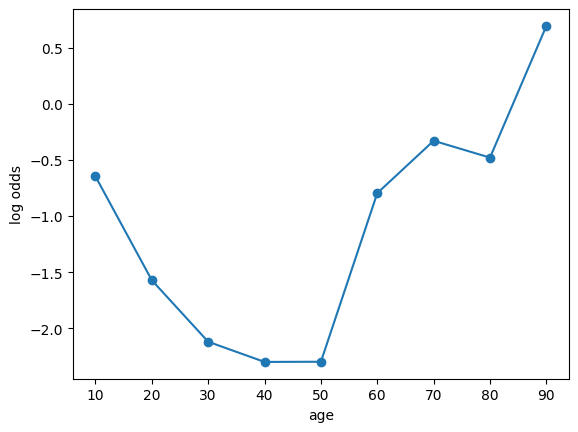

In [14]:
# 年齢と対数オッズの散布図を描く
plt.plot(logodds_bin[bin_feature], logodds_bin['log_odds'], marker='o')
plt.xlabel(bin_feature)
plt.ylabel('log odds')
plt.show()

確認の結果、`age` は欲求に対して線形になっておらず、50代を境にV字を描いていることがわかった。

### `age` の線形化

`age` に対して欲求がV字を描くように変化していることから、新たに以下のような仮説を立てた。

- 50代以前の世代
    - 子供の進学や住宅ローンの返済が重なるため、50代で支出がピークを迎える。
    - ゆえに、50代以前の世代は50代に向けた資産形成が必要。
    - 支出の少ないうちに資産を形成する必要があるため、若いほど定期預金の必要性が増す。
- 60代以降の世代
    - ピークを越え支出が減るものの、退職することから収入も大幅に減る。
    - ゆえに、60代以降の世代は老後に向けた資産形成が必要。
    - 余命が短いとリスクを取れなくなるため、高齢であるほど低リスクな定期預金の必要性が増す。

これらの仮説をまとめると「年齢が50代から離れているほど、定期預金の必要性が増す」ということだから、  
定期預金の必要性を表す変数として `age` の代わりに「50歳から何歳離れているか `margin`」を作成し用いることにした。

In [15]:
train['margin'] = (50 - train['age']).abs()

新たに作成した変数 `margin` が欲求に対して線形になっているか確認する。

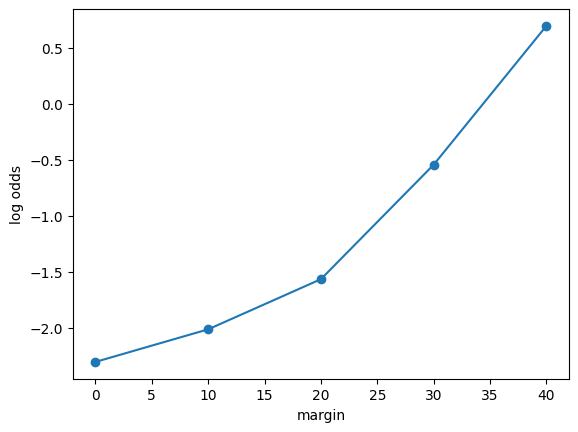

In [16]:
# 年齢別の対数オッズを計算する
logodds_age = train[['margin', 'y']].copy()
logodds_age['margin'] = logodds_age['margin'] // 10 * 10  # 10歳刻みに変換
logodds_age = logodds_age.groupby(['margin'], as_index=False)['y'].apply(calc_logodds)

# 年齢と対数オッズの散布図を描く
plt.plot(logodds_age['margin'], logodds_age['y'], marker='o')
plt.xlabel('margin')
plt.ylabel('log odds')
plt.show()

確認の結果、概ね線形になっており、ロジスティック回帰モデルの仮定を満たしていることがわかった。

### 予測精度の確認

`age` の代わりに `margin` を用いてモデルを構築し、その予測精度をクロスバリデーションで確認する。

In [17]:
# 学習データ
train_x = train[['margin', 'balance']].copy()
train_y = train['y'].copy()

# ロジスティック回帰モデルを作成する
model = LogisticRegression(solver="liblinear")

# クロスバリデーション
cv = cross_validate(
    # クロスバリデーションに用いるモデルとデータを指定する
    model, train_x, train_y,
    # データの分割方法を指定する
    # データを5分割する、分割前にデータをシャッフルする、再現性を担保するためシャッフル時の乱数を固定する
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=37),
    # 予測精度としてAUCを使う
    scoring='roc_auc',
    # 学習データに対する予測精度も計算する
    return_train_score=True,
    # 各foldで学習させたモデルを返す
    return_estimator=True
)

In [18]:
# 学習データに対するAUC
cv['train_score'].mean()

np.float64(0.5900071364616503)

In [19]:
# テストデータに対するAUC
cv['test_score'].mean()

np.float64(0.5897671425526009)

`age` を `margin` へ差し替えたことで、0.54から0.59へ予測精度が向上した。  
同様に係数を確認

In [20]:
coef_cv = make_df_coef_cv(cv)
#各係数を確認
coef_cv.pivot_table(
    index = "cv",
    columns = "feature",
    values = "coefficient",
    aggfunc = "mean"
)

feature,balance,intercept,margin
cv,,,
1,0.000041,-2.609964,0.041701
2,0.000039,-2.611998,0.041995
3,0.000040,-2.621105,0.042583
4,0.000040,-2.618836,0.042382
5,0.000040,-2.586788,0.040256
6,0.000039,-2.588965,0.040461
7,0.000039,-2.594332,0.040611
8,0.000039,-2.580738,0.039814
9,0.000040,-2.611284,0.041971


marginに対して正の係数が大きくなり、50歳から離れるにつれ欲求が強くなる傾向を推定できている。

---

## 3回目：`balance` の外れ値処理

### `balance` の線形性の確認

`age` と同様に、`balance` についても欲求に対して線形になっているか確認する。

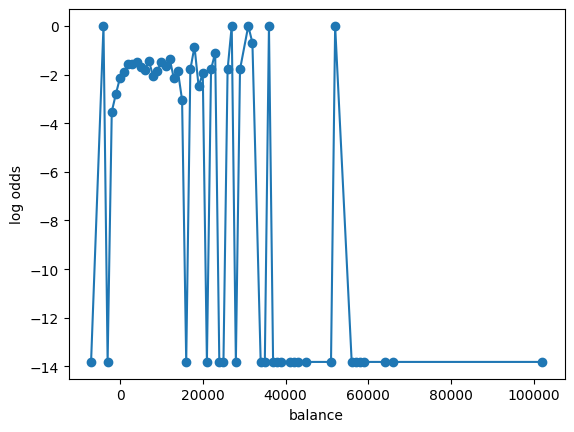

In [21]:
# 残高別の対数オッズを計算する
logodds_balance = train[['balance', 'y']].copy()
logodds_balance['balance'] = logodds_balance['balance'] // 1000 * 1000  # €1,000 (約10万円) 刻みに変換
logodds_balance = logodds_balance.groupby(['balance'], as_index=False)['y'].apply(calc_logodds)

# 残高と対数オッズの散布図を描く
plt.plot(logodds_balance['balance'], logodds_balance['y'], marker='o')
plt.xlabel('balance')
plt.ylabel('log odds')
plt.show()

確認の結果、線形性以前に、`balance` が少ない場合や多い場合に対数オッズが極端な値 (特に、極端に小さな値) を取ることがわかった。

### `balance` の分布の確認

対数オッズが極端な値を取るのは、`balance` の少ない層や高い層が数名しかいないためだと考えられる。  
そこで、`balance` の分布を確認する。

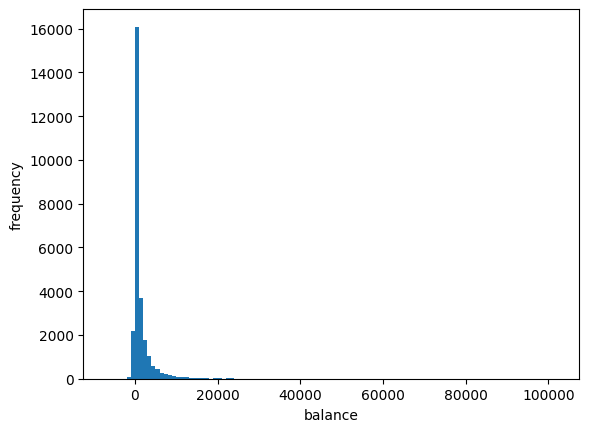

In [22]:
plt.hist(train['balance'], bins=logodds_balance['balance'])
plt.xlabel('balance')
plt.ylabel('frequency')
plt.show()

In [23]:
train['balance'].quantile([0.00, 0.05, 0.25, 0.5, 0.75, 0.95, 1.00])

0.00     -6847.0
0.05      -176.0
0.25        72.0
0.50       449.0
0.75      1428.0
0.95      5704.0
1.00    102127.0
Name: balance, dtype: float64

確認の結果、大部分の顧客は [€-176, €5,704] の範囲に収まっており、  
`balance` が大きくマイナス or プラスになる層はごく一部であることがわかった。

### `balance` の外れ値の処理

このままモデルを構築すると、`balance` が小さい or 大きい層の極端に小さな対数オッズに引っ張られて、  
顧客全体の対数オッズ (＝欲求) が低く見積もられてしまう。  
そこで、以下のような仮説を立て、外れ値に対処しつつ `balance` がより正確に資産的余裕を表すよう処理した。

- 残高マイナスの顧客の資産的余裕は、定期預金口座に預ける資産がないわけだから残高0の顧客と同じ。
    - → `balance` がマイナスの場合、`0` に置き換える。
- 収入が増えても支出はあまり変わらないから、残高 (≒収入) の増加に対して資産的余裕の増加は徐々に収束する。
    - → `balance` が「資産的余裕が収束した時の値」を超えた場合、その「資産的余裕が収束した時の値」に置き換える。
    - ここでは「資産的余裕が収束した時の値」の見積もりとして、`balance` の95%点を用いる。

外れ値の上下限処理としてPandasのclipメソッドを使用します。  
これは引数lowerの設定で値の下限を揃え、引数upperの設定で値の上限を揃える処理です。

In [24]:
train['trimmed_balance'] = train['balance'].copy()
train['trimmed_balance'] = train['trimmed_balance'].clip(lower = 0,upper = 5704)

外れ値処理後の `balance` が欲求に対して線形になっているか確認する。

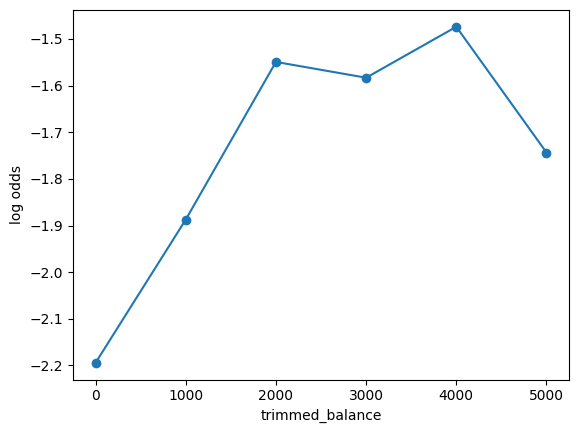

In [25]:
# 残高別の対数オッズを計算する
logodds_balance = train[['trimmed_balance', 'y']].copy()
logodds_balance['trimmed_balance'] = logodds_balance['trimmed_balance'] // 1000 * 1000  # €1,000 (約10万円) 刻みに変換
logodds_balance = logodds_balance.groupby(['trimmed_balance'], as_index=False)['y'].apply(calc_logodds)

# 残高と対数オッズの散布図を描く
plt.plot(logodds_balance['trimmed_balance'], logodds_balance['y'], marker='o')
plt.xlabel('trimmed_balance')
plt.ylabel('log odds')
plt.show()

確認の結果、きれいな線形にはなっていないものの、「`balance` が大きいと欲求も高くなる」という大まかな傾向はあることがわかった。

### 予測精度の確認

外れ値処理後の `balance` を用いてモデルを構築し、その予測精度をクロスバリデーションで確認する。

In [26]:
# 学習データ
train_x = train[['margin', 'trimmed_balance']].copy()
train_y = train['y'].copy()

# ロジスティック回帰モデルを作成する
model = LogisticRegression(solver="liblinear")

# クロスバリデーション
cv = cross_validate(
    # クロスバリデーションに用いるモデルとデータを指定する
    model, train_x, train_y,
    # データの分割方法を指定する
    # データを5分割する、分割前にデータをシャッフルする、再現性を担保するためシャッフル時の乱数を固定する
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=37),
    # 予測精度としてAUCを使う
    scoring='roc_auc',
    # 学習データに対する予測精度も計算する
    return_train_score=True,
    # 各foldで学習させたモデルを返す
    return_estimator=True
)

In [27]:
# 学習データに対するAUC
cv['train_score'].mean()

np.float64(0.6067671376763261)

In [28]:
# テストデータに対するAUC
cv['test_score'].mean()

np.float64(0.6065165544742628)

`balance` の外れ値を処理したことで、0.58から0.60へ予測精度が向上した。  
同様に係数についても確認

In [29]:
coef_cv = make_df_coef_cv(cv)
#各係数を確認
coef_cv.pivot_table(
    index = "cv",
    columns = "feature",
    values = "coefficient",
    aggfunc = "mean"
)

feature,intercept,margin,trimmed_balance
cv,,,
1,-2.763935,0.043428,0.000151
2,-2.735870,0.042654,0.000143
3,-2.771298,0.044274,0.000148
4,-2.768364,0.043977,0.000149
5,-2.711267,0.041035,0.000141
6,-2.711663,0.041005,0.000143
7,-2.750856,0.042350,0.000152
8,-2.710097,0.040578,0.000144
9,-2.737349,0.042828,0.000143


`balance`の外れ値によって正の係数の傾きは小さく推定されていたが、外れ値の上下限処理を行うことで正の傾きは大きく推定された。
- 例として、cv1での`balance`の係数が0.000037となっていたのに対し、`trimmed_balance`では0.000141となっている。

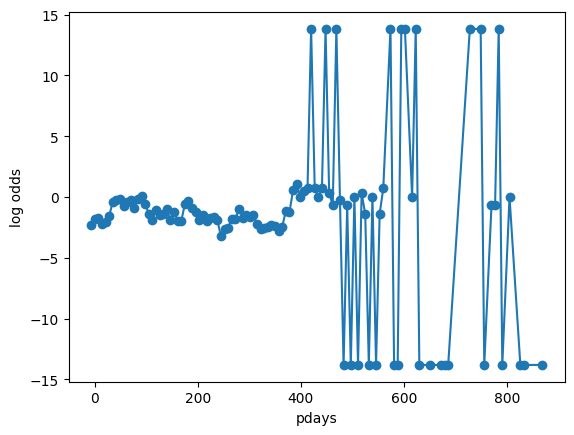

In [30]:
# pdaysの対数オッズを計算する
logodds_pdays = train[['pdays', 'y']].copy()
logodds_pdays['pdays'] = logodds_pdays['pdays'] // 7 * 7  
logodds_pdays = logodds_pdays.groupby(['pdays'], as_index=False)['y'].apply(calc_logodds)

# pdaysと対数オッズの散布図を描く
plt.plot(logodds_pdays['pdays'], logodds_pdays['y'], marker='o')
plt.xlabel('pdays')
plt.ylabel('log odds')
plt.show()

In [31]:
train['pdays'].quantile([0.00, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99, 1.00])

0.00     -1.0
0.05     -1.0
0.25     -1.0
0.50     -1.0
0.75     -1.0
0.95    318.0
0.99    370.0
1.00    871.0
Name: pdays, dtype: float64

In [32]:
train['trimmed_pdays'] = train['pdays'].clip(lower= 0, upper = 365)

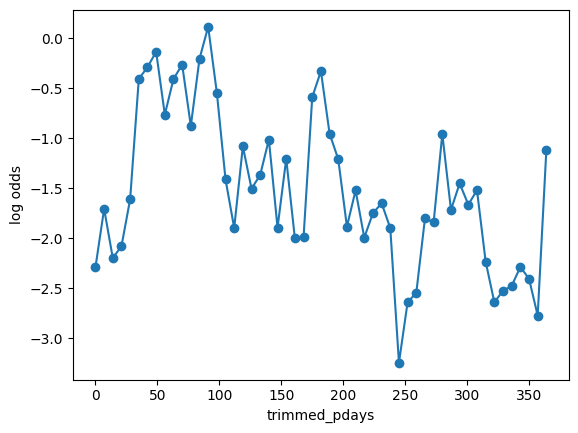

In [33]:
bin_feature = 'trimmed_pdays'

logodds_bin = train[[bin_feature, 'y']].copy()
#logodds_bin[bin_feature] = np.cos(logodds_bin[bin_feature] * 2 * np.pi / 365)
logodds_bin[bin_feature] = logodds_bin[bin_feature] //7 *7
logodds_bin = logodds_bin.groupby([bin_feature], as_index=False).agg({'y':['count','mean',calc_logodds]})

logodds_bin.columns = [bin_feature,'N','y_mean','log_odds']
#オッズの散布図を描く
plt.plot(logodds_bin[bin_feature], logodds_bin['log_odds'], marker='o')
plt.xlabel(bin_feature)
plt.ylabel('log odds')
plt.show()

In [34]:
# 学習データ
train_x = train[['margin', 'trimmed_balance','trimmed_pdays']].copy()
train_y = train['y'].copy()

# ロジスティック回帰モデルを作成する
model = LogisticRegression(solver="liblinear")

# クロスバリデーション
cv = cross_validate(
    # クロスバリデーションに用いるモデルとデータを指定する
    model, train_x, train_y,
    # データの分割方法を指定する
    # データを5分割する、分割前にデータをシャッフルする、再現性を担保するためシャッフル時の乱数を固定する
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=37),
    # 予測精度としてAUCを使う
    scoring='roc_auc',
    # 学習データに対する予測精度も計算する
    return_train_score=True,
    # 各foldで学習させたモデルを返す
    return_estimator=True
)
cv['train_score'].mean(), cv['test_score'].mean()

(np.float64(0.636249982909108), np.float64(0.6360340907524599))

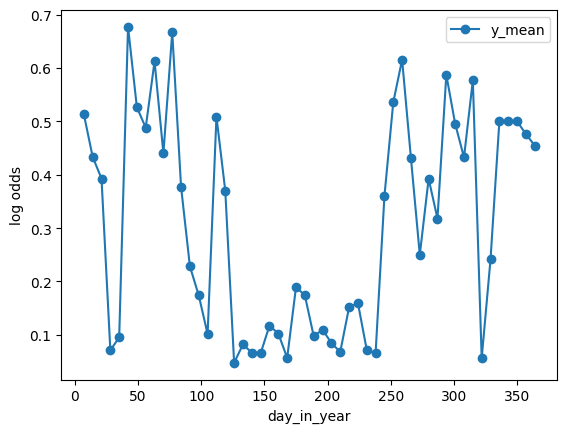

In [35]:
#calculate day in year by combining month and day
train["day_in_year"] = pd.to_datetime( train["month"] + " " + train["day"].astype(str) + " 2020", format="%b %d %Y").dt.dayofyear
#train["day_in_year"]

bin_feature = 'day_in_year'

logodds_bin = train[[bin_feature, 'y']].copy()
#logodds_bin[bin_feature] = np.cos(logodds_bin[bin_feature] * 2 * np.pi / 365)
logodds_bin[bin_feature] = logodds_bin[bin_feature] //7 *7
logodds_bin = logodds_bin.groupby([bin_feature], as_index=False).agg({'y':['sum','count','mean',calc_logodds]})

logodds_bin.columns = [bin_feature,'sum','N','y_mean','log_odds']
#オッズの散布図を描く
plt.plot(logodds_bin[bin_feature], logodds_bin[['y_mean']], marker='o',label =['y_mean'])
plt.xlabel(bin_feature)
plt.ylabel('log odds')
plt.legend()
plt.show()

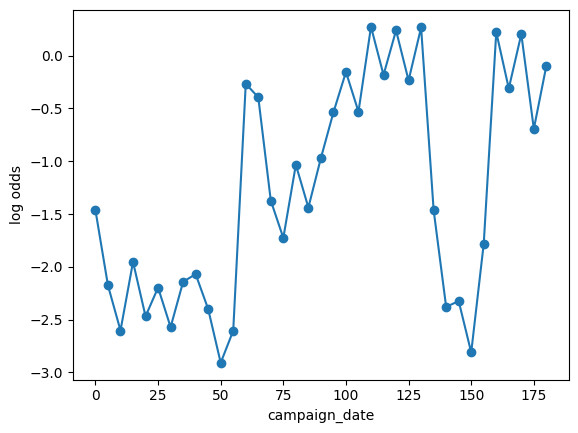

In [38]:
train["campaign_date"] = abs(train["day_in_year"].copy() - 183)
#train["campaign_date"] = np.log1p(train["campaign_date"])

bin_feature = 'campaign_date'

logodds_bin = train[[bin_feature, 'y']].copy()
#logodds_bin[bin_feature] = np.cos(logodds_bin[bin_feature] * 2 * np.pi / 365)
logodds_bin[bin_feature] = logodds_bin[bin_feature] // 5 * 5
logodds_bin = logodds_bin.groupby([bin_feature], as_index=False).agg({'y':['sum','count','mean',calc_logodds]})

logodds_bin.columns = [bin_feature,'sum','N','y_mean','log_odds']
#オッズの散布図を描く
plt.plot(logodds_bin[bin_feature], logodds_bin[['log_odds']], marker='o',label =['log_odds'])
plt.xlabel(bin_feature)
plt.ylabel('log odds')
#plt.legend()
plt.show()

In [37]:
# 学習データ
train_x = train[['campaign_date','margin', 'trimmed_balance','trimmed_pdays']].copy()
train_y = train['y'].copy()

# ロジスティック回帰モデルを作成する
model = LogisticRegression(solver="liblinear")

# クロスバリデーション
cv = cross_validate(
    # クロスバリデーションに用いるモデルとデータを指定する
    model, train_x, train_y,
    # データの分割方法を指定する
    # データを5分割する、分割前にデータをシャッフルする、再現性を担保するためシャッフル時の乱数を固定する
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=37),
    # 予測精度としてAUCを使う
    scoring='roc_auc',
    # 学習データに対する予測精度も計算する
    return_train_score=True,
    # 各foldで学習させたモデルを返す
    return_estimator=True
)
cv['train_score'].mean(), cv['test_score'].mean()

(np.float64(0.6440236429129648), np.float64(0.6433593319963007))

---

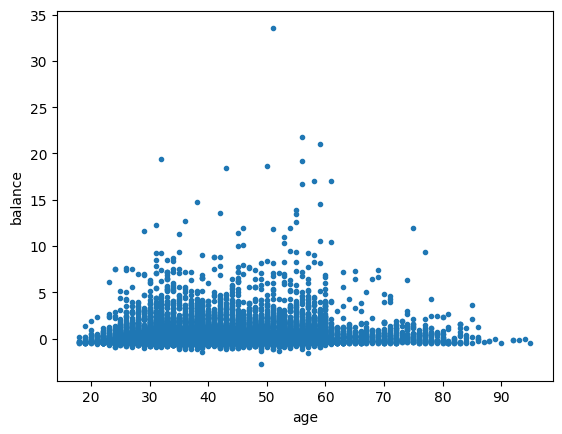

In [51]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
train["balance_z"] = scaler.fit_transform(train_df[['balance']])
plt.scatter(train_df["age"], train["balance_z"], marker='.')
plt.xlabel("age")
plt.ylabel('balance')
plt.show()

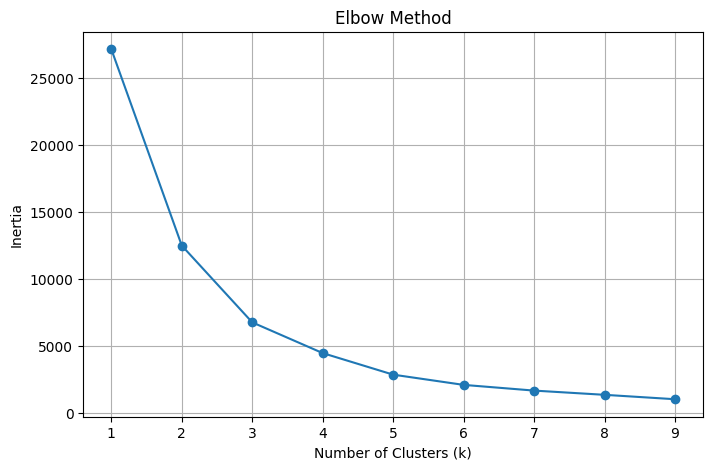

In [65]:
inertia = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(train[["balance_z"]])
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 10), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

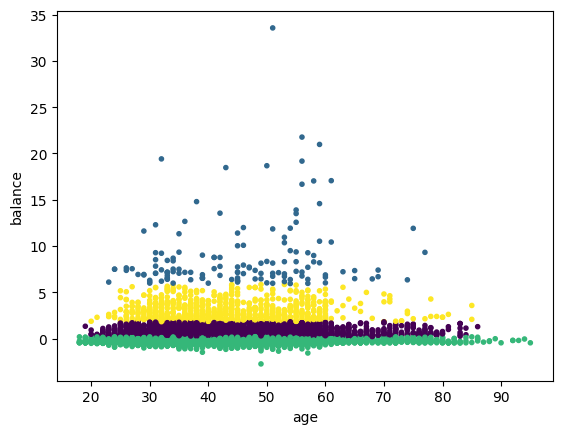

In [69]:
kmeans = KMeans(n_clusters=4, random_state=37, n_init='auto')
train['cluster'] = kmeans.fit_predict(train[["balance_z"]])

plt.scatter(train_df["age"], train["balance_z"], c=train["cluster"],marker='.')
plt.xlabel("age")
plt.ylabel('balance')
plt.show()

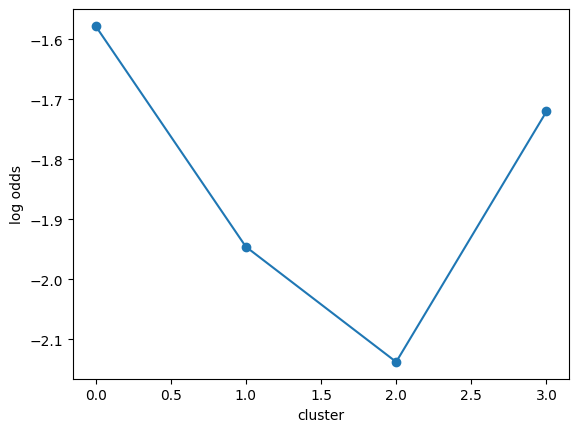

In [70]:
bin_feature = 'cluster'

logodds_bin = train[[bin_feature, 'y']].copy()
#logodds_bin[bin_feature] = np.cos(logodds_bin[bin_feature] * 2 * np.pi / 365)
logodds_bin[bin_feature] = logodds_bin[bin_feature]
logodds_bin = logodds_bin.groupby([bin_feature], as_index=False).agg({'y':['sum','count','mean',calc_logodds]})

logodds_bin.columns = [bin_feature,'sum','N','y_mean','log_odds']
#オッズの散布図を描く
plt.plot(logodds_bin[bin_feature], logodds_bin[['log_odds']], marker='o',label =['log_odds'])
plt.xlabel(bin_feature)
plt.ylabel('log odds')
#plt.legend()
plt.show()

In [71]:
# 学習データ
train_x = train[['campaign_date','margin', 'trimmed_balance','trimmed_pdays','cluster']].copy()
train_y = train['y'].copy()

# ロジスティック回帰モデルを作成する
model = LogisticRegression(solver="liblinear")

# クロスバリデーション
cv = cross_validate(
    # クロスバリデーションに用いるモデルとデータを指定する
    model, train_x, train_y,
    # データの分割方法を指定する
    # データを5分割する、分割前にデータをシャッフルする、再現性を担保するためシャッフル時の乱数を固定する
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=37),
    # 予測精度としてAUCを使う
    scoring='roc_auc',
    # 学習データに対する予測精度も計算する
    return_train_score=True,
    # 各foldで学習させたモデルを返す
    return_estimator=True
)
cv['train_score'].mean(), cv['test_score'].mean()

(np.float64(0.644899044452139), np.float64(0.6442010307197201))